## Importing essential libraries

In [865]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from imblearn.over_sampling import SMOTE

## Reading the Data

In [866]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python')
income.head()
#QC:Checking number of rows and columns 
type(income)
income.shape

(32561, 15)

In [867]:
#Checking for null values
income.isnull()
#Replacing missing values with numpy NaN values  
income.replace('', np.nan, inplace=True)
income.replace('?', np.nan, inplace=True)
#Columns with null/NaN values
income.isnull().any()
#summary of missing values
income.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [868]:
#trim whitespaces if any for columns of type string
income_trimmed = income.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
income_trimmed.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [869]:
income.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [870]:
#Looking for duplicates in the data
income_trimmed.duplicated().sum()
#Removing duplicate entries from our data
income_c =income_trimmed.drop_duplicates()
income_c.shape

(32537, 15)

## Data Pre-Processing & EDA

In [871]:
#Handling Nulls by replacing them with most frequent occurrence
#~6% of the rows collectively have incomplete data 
index=income_c.index

from sklearn.impute import SimpleImputer as Imputer
#creating an object for SimpleImputer
imp_freq=Imputer(missing_values=np.nan,strategy='most_frequent')
income_c=pd.DataFrame(imp_freq.fit_transform(income_c))
income_c.columns = income.columns
income_c.index = index

#Check if imputation worked
income_c.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [872]:
#merging levels of education
income_c['education']=np.where(income_c['education'] =='11th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='9th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='7th-8th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='5th-6th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='10th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='1st-4th', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='Preschool', 'Not-HS-Grad', income_c['education'])
income_c['education']=np.where(income_c['education'] =='12th', 'Not-HS-Grad', income_c['education'])

#unique levels of education
income_c['education'].unique()

array(['Bachelors', 'HS-grad', 'Not-HS-Grad', 'Masters', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', 'Doctorate', 'Prof-school'],
      dtype=object)

In [873]:
#modify education_num in proportion to education
# Create mapper
scale_mapper = {'Not-HS-Grad':1, 
                'HS-grad':2,
                'Some-college':3,
               'Assoc-voc':4,
               'Assoc-acdm':5,
               'Bachelors':6,
               'Masters':7,
               'Prof-school':8,
               'Doctorate':9}
income_c['education']=income_c['education'].replace(scale_mapper)
income_c['education'].unique()

array([6, 2, 1, 7, 3, 5, 4, 9, 8], dtype=int64)

In [874]:
#1:1 mapping between columns 'education-num' and 'education' in the original dataset
#education_num being a quantitative variable will be more valuable in our model than the categorical variable as it has order 
#based on education qualification
income_c.groupby(['education','education-num']).size()

education  education-num
1          1                   50
           2                  166
           3                  332
           4                  645
           5                  514
           6                  933
           7                 1175
           8                  433
2          9                10494
3          10                7282
4          11                1382
5          12                1067
6          13                5353
7          14                1722
8          15                 576
9          16                 413
dtype: int64

Text(0, 0.5, '# of records')

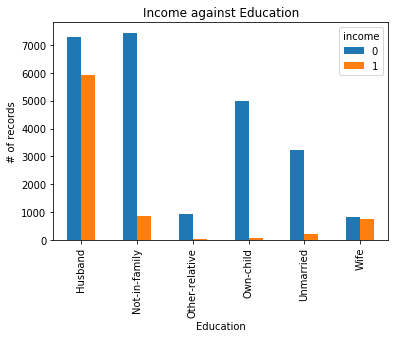

In [875]:
%matplotlib inline
pd.crosstab(income_c['relationship'],income_fact['income']).plot(kind='bar')
plt.title('Income against Education')
plt.xlabel('Education')
plt.ylabel('# of records')

In [876]:
del income_c['education-num']

Text(0, 0.5, 'High Salary Proportion')

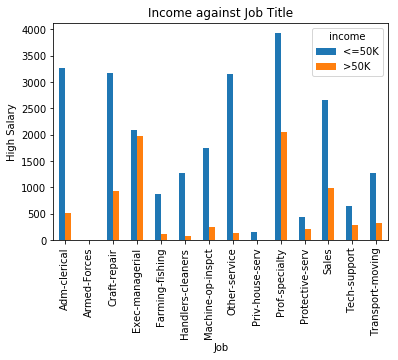

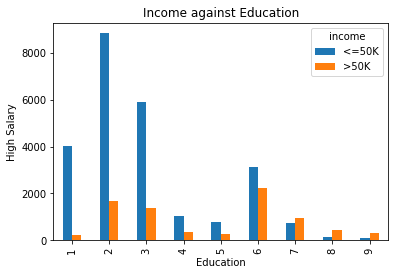

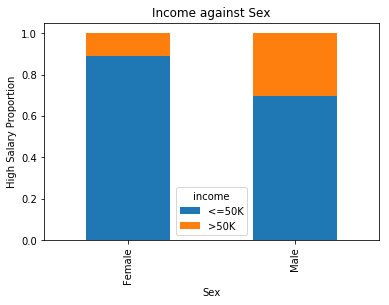

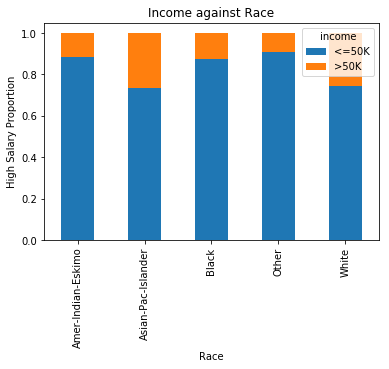

In [877]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income_c['occupation'],income_c['income']).plot(kind='bar')
plt.title('Income against Job Title')
plt.xlabel('Job')
plt.ylabel('High Salary')

pd.crosstab(income_c['education'],income_c['income']).plot(kind='bar')
plt.title('Income against Education')
plt.xlabel('Education')
plt.ylabel('High Salary')

table=pd.crosstab(income_c['sex'],income_c['income'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
plt.title('Income against Sex')
plt.xlabel('Sex')
plt.ylabel('High Salary Proportion')

table1=pd.crosstab(income_c['race'],income_c['income'])
table1.div(table1.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
plt.title('Income against Race')
plt.xlabel('Race')
plt.ylabel('High Salary Proportion')

In [766]:
#checking for class imbalance
print(income_c['income'].value_counts())
print(str(round(income_c['income'].value_counts()*100/income_c.shape[0],2)) + '%')

<=50K    24698
>50K      7839
Name: income, dtype: int64
<=50K    75.91
>50K     24.09
Name: income, dtype: float64%


Text(0, 0.5, '# of records')

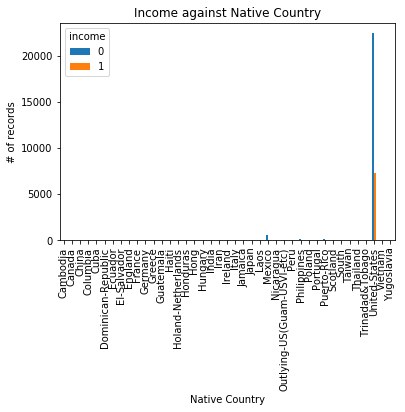

In [767]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income_c['native-country'],income_fact['income']).plot(kind='bar')
plt.title('Income against Native Country')
plt.xlabel('Native Country')
plt.ylabel('# of records')

In [768]:
#since 92% of the records have US as native, adding rest countries into one category called 'Rest'
income_c.loc[income_c['native-country']!='United-States', 'native-country'] = 'Rest'
income_c['native-country'].unique()

array(['United-States', 'Rest'], dtype=object)

In [769]:
#Private house service and Protective service was below 1%, hence merged with other services
income_c.loc[income_c['occupation']=='Priv-house-serv', 'occupation'] = 'Other-service'
income_c.loc[income_c['occupation']=='Protective-serv', 'occupation'] = 'Other-service'
income_c.loc[income_c['occupation']=='Armed-Forces', 'occupation'] = 'Other-service'
income_c['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support'], dtype=object)

In [770]:
print(str(round(income_c['occupation'].value_counts()*100/income_c.shape[0],2)) + '%')

Prof-specialty       18.38
Other-service        12.59
Craft-repair         12.58
Exec-managerial      12.49
Adm-clerical         11.58
Sales                11.22
Machine-op-inspct     6.15
Transport-moving      4.91
Handlers-cleaners     4.21
Farming-fishing       3.05
Tech-support          2.85
Name: occupation, dtype: float64%


In [771]:
print(str(round(income_c['race'].value_counts()*100/income_c.shape[0],2)) + '%')

White                 85.43
Black                  9.60
Asian-Pac-Islander     3.19
Amer-Indian-Eskimo     0.96
Other                  0.83
Name: race, dtype: float64%


In [772]:
#American-Indian-Eskimo and Other were below 1%, hence merged with other
income_c.loc[income_c['race']=='Amer-Indian-Eskimo', 'race'] = 'Other'
income_c['race'].unique()
print(str(round(income_c['race'].value_counts()*100/income_c.shape[0],2)) + '%')

White                 85.43
Black                  9.60
Asian-Pac-Islander     3.19
Other                  1.79
Name: race, dtype: float64%


Text(0, 0.5, '# of records')

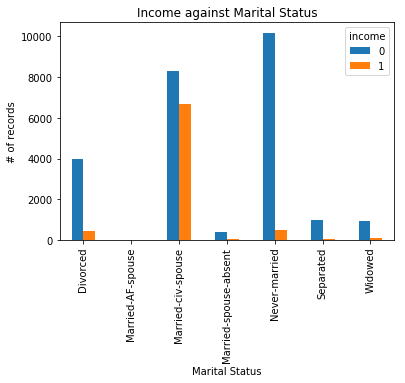

In [773]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income_c['marital-status'],income_fact['income']).plot(kind='bar')
plt.title('Income against Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('# of records')

In [774]:
#all married-regardless of absentee spouse(1.28%), Af-spouse(0.07%), Civ-spouse can be merged into one -married
#Grouping within married-spouse would hardly help explain variation due to sparse presence of 2 of the 3 groups
income_c.loc[income_c['marital-status']=='Married-AF-spouse', 'marital-status'] = 'Married'
income_c.loc[income_c['marital-status']=='Married-spouse-absent', 'marital-status'] = 'Married'
income_c.loc[income_c['marital-status']=='Married-civ-spouse', 'marital-status'] = 'Married'
income_c['marital-status'].unique()

array(['Never-married', 'Married', 'Divorced', 'Separated', 'Widowed'],
      dtype=object)

In [775]:
print(str(round(income_c['marital-status'].value_counts()*100/income_c.shape[0],2)) + '%')
print(str(round(income_c['workclass'].value_counts()*100/income_c.shape[0],2)) + '%')

Married          47.36
Never-married    32.78
Divorced         13.65
Separated         3.15
Widowed           3.05
Name: marital-status, dtype: float64%
Private             75.33
Self-emp-not-inc     7.81
Local-gov            6.43
State-gov            3.99
Self-emp-inc         3.43
Federal-gov          2.95
Without-pay          0.04
Never-worked         0.02
Name: workclass, dtype: float64%


Text(0, 0.5, '# of records')

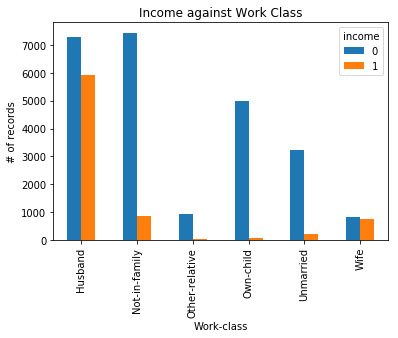

In [776]:
%matplotlib inline
pd.crosstab(income_c['relationship'],income_fact['income']).plot(kind='bar')
plt.title('Income against Work Class')
plt.xlabel('Work-class')
plt.ylabel('# of records')

In [777]:
#although distribution of private is dominating but behavior across other types is varying
#merged never worked and no pay dut to similar income status

income_c.loc[income_c['workclass']=='Without-pay', 'workclass'] = 'No Pay/Job'
income_c.loc[income_c['workclass']=='Never-worked', 'workclass'] = 'No Pay/Job'
income_c['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'No Pay/Job'], dtype=object)

Text(0, 0.5, 'Education')

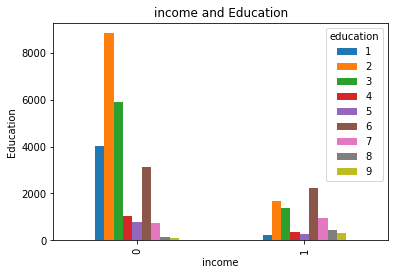

In [808]:
%matplotlib inline
pd.crosstab(income_c['income'],income_c['education']).plot(kind='bar')
plt.title('income and Education')
plt.xlabel('income')
plt.ylabel('Education')

## Creating Dummy Variables

In [778]:
#Creting an array of column names which are to be converted to factors
factors = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

In [779]:
for var in factors:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_c[var], prefix=var)
        income_c = pd.concat([income_c,cat_list], axis = 1)
        income_c = income_c.drop(var, 1)
income_c.columns

Index(['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_No Pay/Job', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'marital-status_Divorced',
       'marital-status_Married', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Prof-specialty',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Husband',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-

Text(0, 0.5, 'Education')

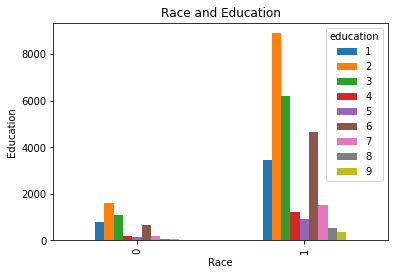

In [803]:
%matplotlib inline
pd.crosstab(income_c['race_White'],income_c['education']).plot(kind='bar')
plt.title('Race and Education')
plt.xlabel('Race')
plt.ylabel('Education')

In [780]:
#Dropping one dummy variable from each categorical var
income_c=income_c.drop(['race_Other','sex_Male','native-country_Rest','relationship_Unmarried',
                      'occupation_Other-service','workclass_No Pay/Job','marital-status_Never-married'],axis=1)

# Test-Training Set Split and Fitting

In [781]:

#70% records being sent into training set 
income_c['income'] = income_c['income'].factorize()[0]
pts = np.random.rand(len(income_c)) < 0.7

income_train = income_c[pts]
income_test = income_c[~pts]

#Prepping the training set
X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

#Prepping the test set
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']

#FULL MODEL - all variables w/o scaling and feature selection
#fitting the model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

[[7120  278]
 [1724  624]]
accuracy score 0.7945823927765236
f1_score 0.384


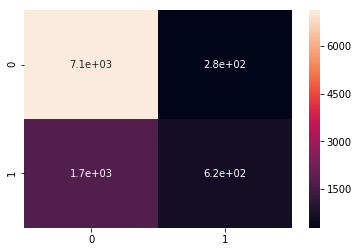

In [648]:
#generating confusion matrix
#generating confusion matrix
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']
Y_pred = logreg.predict(X_test)

#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True)
print(cm)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(Y_test, Y_pred))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(Y_test, Y_pred))

## Feature Scaling (Standardization)

Capital gains and capital losses have wide range
<br>Similarly, scale for age and other quantities are also varying 
<br>We are getting convergence warning on using feature selection methods like RFE and RandomForest Classifier
<br>As we are not using our model for interpretation but prediction of log odds,
<br>To resolve, all of the above we are standardizing our dataset

In [782]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
#Normalizing the training set 
X_train_sc=pd.DataFrame(sc_X.fit_transform(X_train))
X_train_sc.columns=X_train.columns
#Normalizing the test set
X_test_sc=pd.DataFrame(sc_X.transform(X_test))
X_test_sc.columns=X_test.columns

C:\Users\shali\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shali\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\shali\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  import sys


## Feature Selection
<h4> 1. RFE(Recursive Feature Elimination)</h4>

In [783]:
target=Y_train
# feature extraction
from sklearn.feature_selection import RFE
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model)
fit = rfe.fit(X_train_sc, target)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

#Creating a training set with important features
X_train_rfe=X_train_sc[X_train_sc.columns[fit.support_]]
#Creating a test set with important features
X_test_rfe=X_test_sc[X_test_sc.columns[fit.support_]]

Num Features: 18
Selected Features: [ True False  True  True  True  True  True  True  True  True  True  True
 False  True False False False False  True  True False False False False
 False False  True False False  True  True False False False  True False]
Feature Ranking: [ 1 17  1  1  1  1  1  1  1  1  1  1  2  1 12  9  8  6  1  1 10 19  4  5
  3 16  1 13 18  1  1 15 14 11  1  7]


[[6920  505]
 [1032 1341]]
accuracy score 0.8431312512757706
f1_score 0.6356956624792605


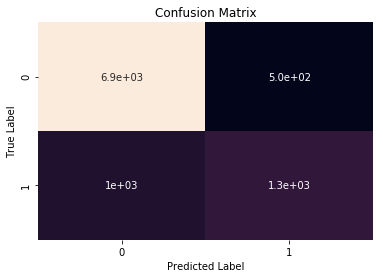

In [784]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train_rfe, Y_train)
Y_pred_rfe = logreg.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_rfe)
sns.heatmap(cm,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
print(cm)

#Testing set accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(Y_test, Y_pred_rfe))

#Precision=True positive / (True positive + False positive)
#Recall=True positive / (True positive + False negative)
#F1 is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
print('f1_score',f1_score(Y_test, Y_pred_rfe))

<h4>2. RFECV(Recursive Feature Elimination with Cross-Fold Validation)</h4>

In [785]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
#Normalizing the training set 
X_train_sc=pd.DataFrame(sc_X.fit_transform(X_train))
X_train_sc.columns=X_train.columns
#Normalizing the test set
X_test_sc=pd.DataFrame(sc_X.transform(X_test))
X_test_sc.columns=X_test.columns

logreg = LogisticRegression(solver='lbfgs')

from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=logreg,  cv=4, scoring='accuracy')
rfecv=rfecv.fit(X_train_sc, Y_train)

C:\Users\shali\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shali\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\shali\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  import sys


In [786]:
print('Optimal number of features: {}'.format(rfecv.n_features_))
cols = X_train_sc.columns[rfecv.support_]
acc = accuracy_score(Y_test, rfecv.estimator_.predict(X_test_sc[cols]))
print('Number of features selected: {}'.format(rfecv.n_features_))
print('Test Accuracy {}'.format(acc))

Optimal number of features: 32
Number of features selected: 32
Test Accuracy 0.844049806082874


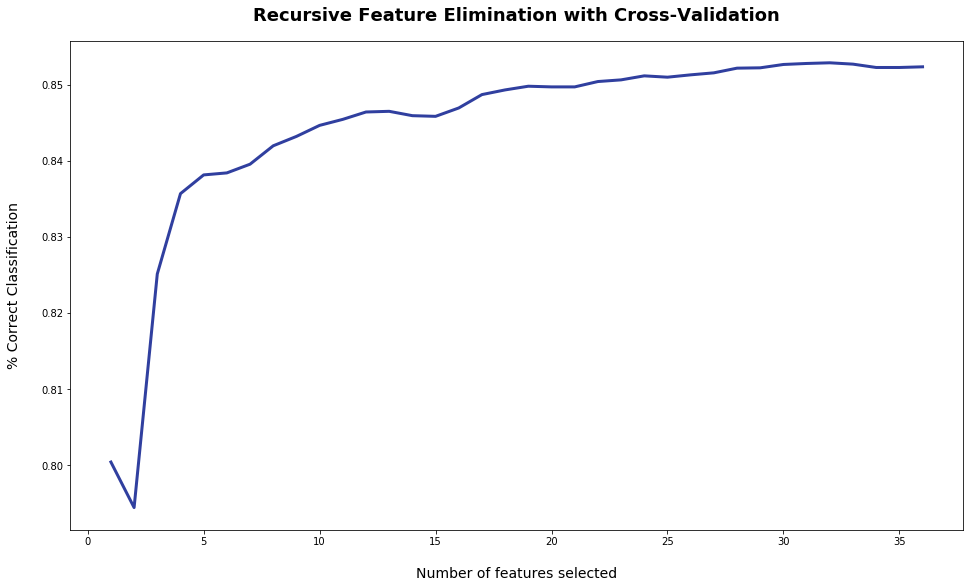

In [787]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

## Linear Regression (Q5,6)
<h4>Q5.</h4>Use the income dataset to regress work hours on the rest of the data. Compare the R^2 with R^2 of another model that you fit with only the significant variables. Explore some interaction terms and explain why they were of interest.

In [849]:
#70% records being sent into training set 
income_c['hours-per-week'] = income_c['hours-per-week'].factorize()[0]
pts = np.random.rand(len(income_c)) < 0.7

Wh_train = income_c[pts]
Wh_test = income_c[~pts]

#Prepping the training set
X_train = Wh_train.copy()
X_train = Wh_train.drop('hours-per-week', 1)
Y_train = Wh_train['hours-per-week']

#Prepping the test set
X_test = Wh_test.copy()
X_test = Wh_test.drop('hours-per-week', 1)
Y_test = Wh_test['hours-per-week']

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html> 
#No constant is added by the model unless you are using formulas in ols

In [850]:
#FULL MODEL - all variables w/o scaling and feature selection
#fitting the model
#No constant is added by the model unless you are using formulas
import statsmodels.api as sm

#Adding constant for beta-zero(intercept)
X_train=sm.add_constant(X_train)
model=sm.OLS(list(Y_train),X_train.astype(float))
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     26.05
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          1.00e-169
Time:                        22:23:02   Log-Likelihood:                -89622.
No. Observations:               22795   AIC:                         1.793e+05
Df Residuals:                   22758   BIC:                         1.796e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [852]:
#Dropping most insignificant columns
#Race_white is the prominent feature, other races are insignificant
#Only widowed seems to be significant enough in marital-status
#Capital-loss and capital -gain gave insignificant results as they have high p-values
#Income is also highly insignificant
#occupation-Farming-Fishing and Prof-Specialty have very high p-value (insignificant)

X_train_new=X_train
X_train_new=X_train_new.drop(['capital-gain','capital-loss','income',
                              'marital-status_Married','marital-status_Separated',
                             'occupation_Prof-specialty','occupation_Farming-fishing','occupation_Sales',
                              'race_Asian-Pac-Islander','race_Black',
                             'relationship_Wife','relationship_Husband','relationship_Other-relative',
                             'relationship_Not-in-family','native-country_United-States',
                             'workclass_Federal-gov','workclass_Local-gov',
                              'workclass_Self-emp-inc','workclass_Self-emp-not-inc','workclass_State-gov']
                             ,1)
import statsmodels.formula.api as sm
model2=sm.OLS(list(Y_train),X_train_new.astype(float))
results=model2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     48.08
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          1.04e-150
Time:                        22:23:34   Log-Likelihood:                -89704.
No. Observations:               22795   AIC:                         1.794e+05
Df Residuals:                   22778   BIC:                         1.796e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [853]:
#Adding an interaction term for education and race
X_train_new['edu*race']=X_train['race_White']*X_train['education']
#dropping the previous interaction term -race*sex
#dropping the previous interaction term -age*sex

import statsmodels.formula.api as sm
model2=sm.OLS(list(Y_train),X_train_new.astype(float))
results=model2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     45.25
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          6.99e-150
Time:                        22:24:42   Log-Likelihood:                -89704.
No. Observations:               22795   AIC:                         1.794e+05
Df Residuals:                   22777   BIC:                         1.796e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [858]:
#The interaction term is highly insignificant
X_train_new=X_train_new.drop('edu*race',1)
#creating an interaction term for age and education
X_train_new['age*edu']=X_train['age']*X_train['education']

import statsmodels.formula.api as sm
model2=sm.OLS(list(Y_train),X_train_new.astype(float))
results=model2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     45.81
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          7.81e-152
Time:                        22:28:45   Log-Likelihood:                -89700.
No. Observations:               22795   AIC:                         1.794e+05
Df Residuals:                   22777   BIC:                         1.796e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<h4>Conclusion:</h4>
As, all the variables except 'age' turned out to be significant. We stopped our process here. We need more features to further improve our model because much of our variation is explained by our intercept ( as can be seen by our high beta-zero coefficient). The existing set of features are significant but not enough.

<h4>Q6.</h4>Regress work hours of only people who are working in Sales. Once you fit a reasonable (as per your judgement) model for this data, compare the R^2 with the ones you calculated for Question 5. Explain your findings.

In [860]:
#Filtering for people who are working in Sales
#70% records being sent into training set
income_s=income_c.loc[income_c['occupation_Sales'] == 1]
income_s['hours-per-week'] = income_s['hours-per-week'].factorize()[0]

#Prepping the training set
X_sales = income_s.copy()
X_sales = income_s.drop('hours-per-week', 1)
Y_sales = income_s['hours-per-week']


#Dropping columns as per our final model
X_sales=X_sales.drop(['capital-gain','capital-loss','income',
                              'marital-status_Married','marital-status_Separated',
                             'occupation_Prof-specialty','occupation_Farming-fishing','occupation_Sales',
                              'race_Asian-Pac-Islander','race_Black',
                             'relationship_Wife','relationship_Husband','relationship_Other-relative',
                             'relationship_Not-in-family','native-country_United-States',
                             'workclass_Federal-gov','workclass_Local-gov',
                              'workclass_Self-emp-inc','workclass_Self-emp-not-inc','workclass_State-gov'],1)

#adding the interaction term for education & age
X_sales['age*edu']=X_sales['education']*X_sales['age']

#Running our model
import statsmodels.api as sm
#adding a constant for beta-zero(intercept)
X_sales=sm.add_constant(X_sales)
model_sales=sm.OLS(list(Y_sales),X_sales.astype(float))
results=model_sales.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     10.62
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           6.06e-18
Time:                        22:49:31   Log-Likelihood:                -13963.
No. Observations:                3650   AIC:                         2.795e+04
Df Residuals:                    3639   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

C:\Users\shali\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [861]:
#Trying another model for sales people

#Removing other occupations as we have selected only those working in Sales -they are hardly making any difference
#Going with the assumption that government roles doesn't involve sales role(or very few)
#having it as separate variables won't add much value to the model
X_sales=X_sales.drop(['occupation_Adm-clerical','occupation_Craft-repair',
                    'occupation_Exec-managerial','occupation_Handlers-cleaners',
                    'occupation_Machine-op-inspct','occupation_Tech-support'],1)
import statsmodels.api as sm
model_sales=sm.OLS(list(Y_sales),X_sales.astype(float))
results=model_sales.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     10.62
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           6.06e-18
Time:                        22:51:38   Log-Likelihood:                -13963.
No. Observations:                3650   AIC:                         2.795e+04
Df Residuals:                    3639   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [862]:
#Checking the model on further removal of insignificant variables
X_sales=X_sales.drop(['race_White','fnlwgt','age','age*edu'],1)#,'fnlwgt','race_White','education'],1)
import statsmodels.formula.api as sm
model_sales=sm.OLS(list(Y_sales),X_sales.astype(float))
results=model_sales.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     15.98
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           3.24e-18
Time:                        22:55:02   Log-Likelihood:                -13968.
No. Observations:                3650   AIC:                         2.795e+04
Df Residuals:                    3643   BIC:                         2.799e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

On further removing insignificant variable, more and more variables turned out to be insignificant. Our R-squared is very low and unstable to use this model even for interpretation. 
<br>We need extra information to further explain the variation in work-hours.